In [1]:
import sys
sys.path.insert(0, "/home/raecker1/3DSSL/")

from pathlib import Path
import torch
import torch.nn.functional as F
import torchvision
import torchio as tio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import nibabel as nib
print(torch.__version__)

from selfsupervised2d.simclr.simclr_module import SimCLR
from selfsupervised3d.simclr.transforms import SimCLRTrainDataTransform, SimCLREvalDataTransform
from selfsupervised2d.simclr.dataset import SimCLR3DDataset, NakoIQADataset, NRUDataset


/opt/conda/raecker1/envs/IQA/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0+cu102


/opt/conda/raecker1/envs/IQA/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/opt/conda/raecker1/envs/IQA/lib/python3.9/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureM

In [2]:
preprocessings = tio.transforms.Compose([
            tio.transforms.ZNormalization(),
            tio.RescaleIntensity((-1, 1))
        ])

val_dataset = SimCLR3DDataset('/mnt/qdata/share/rakuest1/data/UKB/raw/abdominal_MRI/raw/', "/home/raecker1/3DSSL/ukb_abdominal_val_keys.npy",
                    preprocessings, True)

nako_iqa_dataset = NakoIQADataset("/home/raecker1/data/NAKO_IQA/NAKO_IQA_nifti/", preprocessings, suffix="bh_W_COMPOSED")
nako_iqa_dataset_deep = NakoIQADataset("/home/raecker1/data/NAKO_IQA/NAKO_IQA_nifti/", preprocessings, suffix="fb_deep_W_COMPOSED")

#nru_dataset_still = NRUDataset("/home/raecker1/data/NRU/", preprocessings, suffix="01_T1w", infix='_acq-t1tirmpmcoff_rec-wore_run-')
#nru_dataset_nod = NRUDataset("/home/raecker1/data/NRU/", preprocessings, suffix="02_T1w", infix='_acq-t1tirmpmcoff_rec-wore_run-')
#nru_dataset_shake = NRUDataset("/home/raecker1/data/NRU/", preprocessings, suffix="03_T1w", infix = '_acq-mpragepmcoff_rec-wore_run-')


100%|██████████| 19/19 [00:00<00:00, 1159.14it/s]


In [3]:
model = SimCLR.load_from_checkpoint("/home/raecker1/3DSSL/notebooks/weights/2D/wat/epoch=353-step=5017950.ckpt")
device = torch.device("cuda:1")
model.to(device);
model.eval();

Lightning automatically upgraded your loaded checkpoint from v1.7.4 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../raecker1/3DSSL/notebooks/weights/2D/wat/epoch=353-step=5017950.ckpt`


In [4]:
def load_slice(subj_idx, idx, noise=None):
    if noise:
        slice = noise(val_dataset[subj_idx])["data"]["data"][0,:,:,idx]
    else:
        slice = val_dataset[subj_idx]["data"]["data"][0,:,:,idx]
    #slice = np.pad(slice, ((0,0), (28,28)))
    #slice = torch.from_numpy(slice)
    return slice.unsqueeze(0)

def load_slice_nako(subj_idx, idx, noise=None):
    if noise:
        slice = noise(nako_iqa_dataset[subj_idx])["data"]["data"][0,20:-20,:224,idx].unsqueeze(0)
    else:
        slice = nako_iqa_dataset[subj_idx]["data"]["data"][0,20:-20,:224,idx].unsqueeze(0)
        
    print(slice.shape)
    slice = torchvision.transforms.functional.resize(slice, [224, 224])
    #slice = np.pad(slice, ((0,0), (28,28)))
    #slice = torch.from_numpy(slice)
    return slice

def load_slice_nako_deep(subj_idx, idx, noise=None):
    if noise:
        slice = noise(nako_iqa_dataset_deep[subj_idx])["data"]["data"][0,20:-20,:224,idx].unsqueeze(0)
    else:
        slice = nako_iqa_dataset_deep[subj_idx]["data"]["data"][0,20:-20,:224,idx].unsqueeze(0)
        
    print(slice.shape)
    slice = torchvision.transforms.functional.resize(slice, [224, 224])
    #slice = np.pad(slice, ((0,0), (28,28)))
    #slice = torch.from_numpy(slice)
    return slice


def load_slice_nru_still(subj_idx, idx, noise=None):
    if noise:
        slice = noise(nru_dataset_still[subj_idx])["data"]["data"][0,:,:,idx].unsqueeze(0)
    else:
        slice = nru_dataset_still[subj_idx]["data"]["data"][0,:,:,idx].unsqueeze(0)
    return slice

def load_slice_nru_shake(subj_idx, idx, noise=None):
    if noise:
        slice = noise(nru_dataset_shake[subj_idx])["data"]["data"][0,:,:,idx].unsqueeze(0)
    else:
        slice = nru_dataset_shake[subj_idx]["data"]["data"][0,:,:,idx].unsqueeze(0)
    return slice

def load_slice_nru_nod(subj_idx, idx, noise=None):
    if noise:
        slice = noise(nru_dataset_nod[subj_idx])["data"]["data"][0,:,:,idx].unsqueeze(0)
    else:
        slice = nru_dataset_nod[subj_idx]["data"]["data"][0,:,:,idx].unsqueeze(0)
    return slice

In [ ]:
# NAKO IQA: Denbi:/mnt/qdata/rawdata/nakoiqa  Nifti: /mnt/qdata/rawdata/MoCoMedGAN/NAKO_IQA_nifti

In [5]:
reference_keys = pd.read_csv('/home/raecker1/3DSSL/selfsupervised2d/QualityControlExperiments/ref_keys.csv')
root_path = '/mnt/qdata/share/rakuest1/data/UKB/raw/abdominal_MRI/raw/'
ref_paths = []
for subject in reference_keys['eid']:
    path = Path(root_path)/str(subject)/"wat.nii.gz"
    idx = val_dataset.subjects_paths.index(path)
    

In [ ]:
test_id = 64
ref_idc = [1, 2, 3, 4, 5]

"""motion_test = tio.Motion(degrees=np.array([[1.5, 1.5, 1.5]]), translation=np.array([[1.5, 1.5, 1.5]]),
                      times=np.array([0.5]), image_interpolation='linear')

motion_1 = tio.Motion(degrees=np.array([[0.5, 0.5, 0.5]]), translation=np.array([[0.5, 0.5, 0.5]]),
                      times=np.array([0.5]), image_interpolation='linear')
motion_2 = tio.Motion(degrees=np.array([[1.0, 1.0, 1.0]]), translation=np.array([[1.0, 1.0, 1.0]]),
                      times=np.array([0.5]), image_interpolation='linear')
motion_3 = tio.Motion(degrees=np.array([[1.5, 1.5, 1.5]]), translation=np.array([[1.5, 1.5, 1.5]]),
                      times=np.array([0.5]), image_interpolation='linear')
motion_4 = tio.Motion(degrees=np.array([[2.0, 2.0, 2.0]]), translation=np.array([[2.0, 2.0, 2.0]]),
                      times=np.array([0.5]), image_interpolation='linear')"""
noise_test = tio.Noise(mean=0.0, std=0.3, seed=29)
noise_1 = tio.Noise(mean=0.0, std=0.1, seed=29)
noise_2 = tio.Noise(mean=0.0, std=0.2, seed=29)
noise_3 = tio.Noise(mean=0.0, std=0.3, seed=29)
noise_4 = tio.Noise(mean=0.0, std=0.4, seed=29)
                      

#ref_motion_list = ['_', motion_1, motion_2, motion_3, motion_4]
ref_noise_list = ['_', noise_1, noise_2, noise_3, noise_4]


for slc in tqdm([100]):
    slice_test = load_slice(test_id, slc, noise_test)
    feat_test = model(slice_test.unsqueeze(0).to(device))
    sim = {}
    for Q, noise in enumerate(ref_noise_list):
        sim[f'Q{Q+1}'] = []
        for ref_id in ref_idc:
            if noise == '_':
                slice_ref = load_slice(ref_id, slc)
                slice_ref_sub = torch.sub(slice_ref, slice_ref)
            else:
                slice_ref = load_slice(ref_id, slc)
                slice_ref_noise = load_slice(ref_id, slc, noise)
                slice_ref_sub = torch.sub(slice_ref_noise, slice_ref)
            feat_ref = model(slice_ref_sub.unsqueeze(0).to(device))
            sim[f'Q{Q+1}'].append(F.cosine_similarity(feat_test, feat_ref))
        sim[f'Q{Q+1}'] = torch.stack(sim[f'Q{Q+1}']).mean()
    plt.imshow(np.rot90(slice_test[0], 1))
    plt.title(f'UKB ID sub noise Q1 groups: {test_id}, slice: {slc}, sim to Q1: {round(float(sim["Q1"]), 3)}, Q2: {round(float(sim["Q2"]), 3)}, Q3: {round(float(sim["Q3"]), 3)}, Q4: {round(float(sim["Q4"]), 3)}, Q5: {round(float(sim["Q5"]), 3)}')
    plt.show()    
    #plt.savefig(f'/home/raecker1/3DSSL/selfsupervised2d/QualityControlExperiments/results/test_classification_{test_id}_slc{slc}.png')
    plt.close()

"""                slice_ref = load_slice(ref_id, slc)
            slice_ref_motion = load_slice(ref_id, slc, motion)
            slice_ref_sub = torch.sub(slice_ref_motion, slice_ref) 
"""

NRU Brain Data 2D

In [ ]:
test_id = 15
slc = 0

ref_idx = list(range(5))

for slc in tqdm([13]):
    sim_HQ = []
    sim_LQ = []
    for idx in ref_idx:
        slice_test = load_slice_nru_still(test_id, slc)
        slice_HQ = load_slice_nru_still(idx, slc)
        slice_LQ = load_slice_nru_nod(idx, slc)
        feat_test = model(slice_test.unsqueeze(0).to(device))
        feat_HQ = model(slice_HQ.unsqueeze(0).to(device))
        feat_LQ = model(slice_LQ.unsqueeze(0).to(device))
        sim_HQ.append(F.cosine_similarity(feat_test, feat_HQ))
        sim_LQ.append(F.cosine_similarity(feat_test, feat_LQ))
    sim_HQ = torch.stack(sim_HQ).mean()
    sim_LQ = torch.stack(sim_LQ).mean()
    print(f'Mean similarity to HQ references: {sim_HQ}')
    print(f'Mean similarity to LQ reference: {sim_LQ}')
    plt.imshow(np.rot90(slice_test[0], 1), cmap='gray')
    plt.title(f'NRU t1stir nod still ID: {test_id}, slice: {slc}, mean sim to HQ ref: {round(float(sim_HQ), 3)}/ LQ ref: {round(float(sim_LQ), 3)}')
    plt.show()
    #plt.savefig(f'/home/raecker1/3DSSL/selfsupervised2d/QualityControlExperiments/results/meansim_nru_shake_deep_id{test_id}_slc{slc}.png')
    plt.close()

NRU Brain Data 3D

In [ ]:
test_id = 15
slc = 150

ref_idx = list(range(5))

for slc in tqdm(range(150, 200, 10)):
    sim_HQ = []
    sim_LQ = []
    for idx in ref_idx:
        slice_test = load_slice_nru_nod(test_id, slc)
        slice_HQ = load_slice_nru_still(idx, slc)
        slice_LQ = load_slice_nru_nod(idx, slc)
        feat_test = model(slice_test.unsqueeze(0).to(device))
        feat_HQ = model(slice_HQ.unsqueeze(0).to(device))
        feat_LQ = model(slice_LQ.unsqueeze(0).to(device))
        sim_HQ.append(F.cosine_similarity(feat_test, feat_HQ))
        sim_LQ.append(F.cosine_similarity(feat_test, feat_LQ))
    sim_HQ = torch.stack(sim_HQ).mean()
    sim_LQ = torch.stack(sim_LQ).mean()
    print(f'Mean similarity to HQ references: {sim_HQ}')
    print(f'Mean similarity to LQ reference: {sim_LQ}')
    plt.imshow(np.rot90(slice_test[0], 1))
    plt.title(f'NRU nod ID: {test_id}, slice: {slc}, mean sim to HQ ref: {round(float(sim_HQ), 3)}/ LQ ref: {round(float(sim_LQ), 3)}')
    plt.show()
    #plt.savefig(f'/home/raecker1/3DSSL/selfsupervised2d/QualityControlExperiments/results/meansim_nru_shake_deep_id{test_id}_slc{slc}.png')
    plt.close()

Simulation of Motion

In [18]:
test_id = 64
reference_keys = pd.read_csv('/home/raecker1/3DSSL/selfsupervised2d/QualityControlExperiments/ref_keys.csv')
root_path = '/mnt/qdata/share/rakuest1/data/UKB/raw/abdominal_MRI/raw/'
ref_idx = []
for subject in reference_keys['eid']:
    path = Path(root_path)/str(subject)/"wat.nii.gz"
    ref_idx.append(val_dataset.subjects_paths.index(path))
slc = 265

#noise = tio.Compose([tio.transforms.RandomNoise(mean=0, std=(0, 0.5))])
#noise = tio.Compose([tio.transforms.RandomNoise(mean=0, std=(0, 0.5))])
#motion_lq = tio.Compose([tio.transforms.RandomMotion(num_transforms=1)])


motion_1 = tio.Motion(degrees=np.array([[0.0, 0.0, 0.0]]), translation=np.array([[0.0, 0.0, 0.0]]),
                      times=np.array([0.5]), image_interpolation='linear')
motion_2 = tio.Motion(degrees=np.array([[0.5, 0.5, 0.5]]), translation=np.array([[0.5, 0.5, 0.5]]),
                      times=np.array([0.5]), image_interpolation='linear')
motion_3 = tio.Motion(degrees=np.array([[1.0, 1.0, 1.0]]), translation=np.array([[1.0, 1.0, 1.0]]),
                      times=np.array([0.5]), image_interpolation='linear')
motion_4 = tio.Motion(degrees=np.array([[1.5, 1.5, 1.5]]), translation=np.array([[1.5, 1.5, 1.5]]),
                      times=np.array([0.5]), image_interpolation='linear')
motion_5 = tio.Motion(degrees=np.array([[2.0, 2.0, 2.0]]), translation=np.array([[2.0, 2.0, 2.0]]),
                      times=np.array([0.5]), image_interpolation='linear')
motion_6 = tio.Motion(degrees=np.array([[2.5, 2.5, 2.5]]), translation=np.array([[2.5, 2.5, 2.5]]),
                      times=np.array([0.5]), image_interpolation='linear')
motion_7 = tio.Motion(degrees=np.array([[3.0, 3.0, 3.0]]), translation=np.array([[3.0, 3.0, 3.0]]),
                      times=np.array([0.5]), image_interpolation='linear')

for i, motion in enumerate([motion_1, motion_2, motion_3, motion_4, motion_5, motion_6, motion_7]):
    sim_HQ = []
    sim_LQ = []
    for idx in tqdm(ref_idx):
        slice_test = load_slice(test_id, slc, motion)
        slice_HQ = load_slice(idx, slc)
        slice_LQ = load_slice(idx, slc, noise)
        feat_test = model(slice_test.unsqueeze(0).to(device))
        feat_HQ = model(slice_HQ.unsqueeze(0).to(device))
        feat_LQ = model(slice_LQ.unsqueeze(0).to(device))
        sim_HQ.append(F.cosine_similarity(feat_test, feat_HQ))
        sim_LQ.append(F.cosine_similarity(feat_test, feat_LQ))
    sim_HQ = torch.stack(sim_HQ).mean()
    sim_LQ = torch.stack(sim_LQ).mean()
    print(f'Mean similarity to HQ references: {sim_HQ}')
    print(f'Mean similarity to LQ reference: {sim_LQ}')
    plt.imshow(np.rot90(slice_test[0], 1), cmap='gray')
    plt.title(f'ID Motion {i}: {test_id}, slice: {slc}, mean sim to HQ ref: {round(float(sim_HQ), 3)}/ LQ ref: {round(float(sim_LQ), 3)}')
    #plt.show()
    plt.savefig(f'/home/raecker1/3DSSL/selfsupervised2d/QualityControlExperiments/results/fig_meansim_motion_{i}_id{test_id}_slc{slc}.png')
    plt.close()




100%|██████████| 20/20 [01:39<00:00,  4.98s/it]


Mean similarity to HQ references: 0.876533031463623
Mean similarity to LQ reference: 0.2570323944091797


100%|██████████| 20/20 [01:38<00:00,  4.90s/it]


Mean similarity to HQ references: 0.49302443861961365
Mean similarity to LQ reference: 0.3744514584541321


100%|██████████| 20/20 [01:38<00:00,  4.93s/it]


Mean similarity to HQ references: 0.4992656707763672
Mean similarity to LQ reference: 0.37622585892677307


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Mean similarity to HQ references: 0.4901440739631653
Mean similarity to LQ reference: 0.4658920466899872


100%|██████████| 20/20 [01:37<00:00,  4.89s/it]


Mean similarity to HQ references: 0.4832693636417389
Mean similarity to LQ reference: 0.5200648307800293


100%|██████████| 20/20 [01:38<00:00,  4.93s/it]


Mean similarity to HQ references: 0.47179681062698364
Mean similarity to LQ reference: 0.5123690962791443


100%|██████████| 20/20 [01:37<00:00,  4.88s/it]


Mean similarity to HQ references: 0.46643874049186707
Mean similarity to LQ reference: 0.5435437560081482


UKB: mean of similarities to 20 reference HQ/LQ images:

  0%|          | 0/1 [00:00<?, ?it/s]

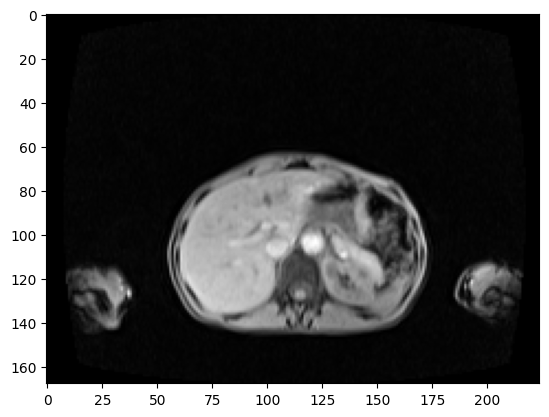

  0%|          | 0/1 [00:40<?, ?it/s]


KeyboardInterrupt: 

In [10]:
test_id = 25
reference_keys = pd.read_csv('/home/raecker1/3DSSL/selfsupervised2d/QualityControlExperiments/ref_keys.csv')
root_path = '/mnt/qdata/share/rakuest1/data/UKB/raw/abdominal_MRI/raw/'
ref_idx = []
for subject in reference_keys['eid']:
    path = Path(root_path)/str(subject)/"wat.nii.gz"
    ref_idx.append(val_dataset.subjects_paths.index(path))

noise = tio.Compose([tio.transforms.RandomNoise(mean=0, std=(0, 0.25))])
#noise = tio.Compose([tio.transforms.RandomMotion(num_transforms=1)])
#noise = tio.Motion(degrees=np.array([[1.0, 1.0, 1.0]]), translation=np.array([[1.0, 1.0, 1.0]]),
#                      times=np.array([0.5]), image_interpolation='linear')
for slc in tqdm([250]):
    sim_HQ = []
    sim_LQ = []
    for idx in ref_idx:
        slice_test = load_slice(test_id, slc)
        slice_HQ = load_slice(idx, slc)
        slice_LQ = load_slice(idx, slc, noise)
        feat_test = model(slice_test.unsqueeze(0).to(device))
        feat_HQ = model(slice_HQ.unsqueeze(0).to(device))
        feat_LQ = model(slice_LQ.unsqueeze(0).to(device))
        sim_HQ.append(F.cosine_similarity(feat_test, feat_HQ))
        sim_LQ.append(F.cosine_similarity(feat_test, feat_LQ))
    sim_HQ = torch.stack(sim_HQ).mean()
    sim_LQ = torch.stack(sim_LQ).mean()
    print(f'Mean similarity to HQ references: {sim_HQ}')
    print(f'Mean similarity to LQ reference: {sim_LQ}')
    plt.imshow(np.rot90(slice_test[0], 1), cmap='gray')
    plt.title(f'ID Noise: {test_id}, slice: {slc}, mean sim to HQ ref: {round(float(sim_HQ), 3)}/ LQ ref: {round(float(sim_LQ), 3)}')
    plt.savefig(f'/home/raecker1/3DSSL/selfsupervised2d/QualityControlExperiments/results/test_fig_meansim_randomnoise_new_id{test_id}_slc{slc}.png')
    #plt.show()
    plt.close()



NAKO IQA: mean of similarities to 5 reference HQ/LQ images:

In [8]:
test_id = 15

ref_idx = list(range(5))

#for slc in tqdm(range(0, 200, 10)):
for slc in tqdm([50,100,150,200]):
    sim_HQ = []
    sim_LQ = []
    for idx in ref_idx:
        #slice_test = load_slice_nako(test_id, slc)
        slice_test = load_slice_nako_deep(test_id, slc)
        slice_HQ = load_slice_nako(idx, slc)
        slice_LQ = load_slice_nako_deep(idx, slc)
        feat_test = model(slice_test.unsqueeze(0).to(device))
        feat_HQ = model(slice_HQ.unsqueeze(0).to(device))
        feat_LQ = model(slice_LQ.unsqueeze(0).to(device))
        sim_HQ.append(F.cosine_similarity(feat_test, feat_HQ))
        sim_LQ.append(F.cosine_similarity(feat_test, feat_LQ))
    sim_HQ = torch.stack(sim_HQ).mean()
    sim_LQ = torch.stack(sim_LQ).mean()
    print(f'Mean similarity to HQ references: {sim_HQ}')
    print(f'Mean similarity to HQ reference: {sim_LQ}')
    plt.imshow(np.rot90(slice_test[0], 1), cmap='gray')
    plt.title(f'NAKO IQA BH ID: {test_id}, slice: {slc}, mean sim to HQ ref: {round(float(sim_HQ), 3)}/ LQ ref: {round(float(sim_LQ), 3)}')
    #plt.show()
    plt.savefig(f'/home/raecker1/3DSSL/selfsupervised2d/QualityControlExperiments/results/fig_meansim_nakoiqa_fb_id{test_id}_slc{slc}.png')
    plt.close()
    



  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
Mean similarity to HQ references: 0.7880452871322632
Mean similarity to HQ reference: 0.8347644209861755


 25%|██▌       | 1/4 [00:17<00:53, 17.89s/it]

torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
Mean similarity to HQ references: 0.8082807660102844
Mean similarity to HQ reference: 0.8629345297813416


 50%|█████     | 2/4 [00:36<00:36, 18.05s/it]

torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
Mean similarity to HQ references: 0.7937653660774231
Mean similarity to HQ reference: 0.8482601046562195


 75%|███████▌  | 3/4 [00:53<00:17, 17.92s/it]

torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
Mean similarity to HQ references: 0.7965432405471802
Mean similarity to HQ reference: 0.8192833065986633


100%|██████████| 4/4 [01:11<00:00, 17.94s/it]


In [ ]:
test_id = 10

ref_idx = list(range(5))

for slc in tqdm(range(0, 200, 10)):
    sim_HQ = []
    sim_LQ = []
    for idx in ref_idx:
        #slice_test = load_slice_nako(test_id, slc)
        slice_test = load_slice_nako_deep(test_id, slc)
        slice_HQ = load_slice_nako(idx, slc)
        slice_LQ = load_slice_nako_deep(idx, slc)
        feat_test = model(slice_test.unsqueeze(0).to(device))
        feat_HQ = model(slice_HQ.unsqueeze(0).to(device))
        feat_LQ = model(slice_LQ.unsqueeze(0).to(device))
        sim_HQ.append(F.cosine_similarity(feat_test, feat_HQ))
        sim_LQ.append(F.cosine_similarity(feat_test, feat_LQ))
    sim_HQ = torch.stack(sim_HQ).mean()
    sim_LQ = torch.stack(sim_LQ).mean()
    print(f'Mean similarity to HQ references: {sim_HQ}')
    print(f'Mean similarity to HQ reference: {sim_LQ}')
    plt.imshow(slice_test[0])
    plt.title(f'NAKO IQA FB ID: {test_id}, slice: {slc}, mean sim to HQ ref: {round(float(sim_HQ), 3)}/ LQ ref: {round(float(sim_LQ), 3)}')
    plt.show()
    #plt.savefig(f'/home/raecker1/3DSSL/selfsupervised2d/QualityControlExperiments/results/test_meansim_nakoiqa_fb_deep_id{test_id}_slc{slc}.png')
    plt.close()
    



In [ ]:
noise = tio.Compose([tio.transforms.RandomGhosting()])
#noise = tio.Compose([tio.transforms.RandomNoise()])

idx0 = 112
idx1 = idx0
patient0 = 0
patient1 = 34

slice0 = load_slice(patient0,idx0)
slice1 = load_slice(patient1,idx1)
slice1_noise = load_slice(patient1,idx1, noise)

fig, axis = plt.subplots(1, 3, figsize=(10,3))
axis[0].imshow(np.rot90(slice0[0][:, 28:-28], 1))
axis[0].set_title("Img0, high quality")
axis[1].imshow(np.rot90(slice1[0][:, 28:-28],1))
axis[1].set_title("Img1, high quality")

axis[2].imshow(np.rot90(slice1_noise[0][:, 28:-28],1))
axis[2].set_title("Img1, low quality")

axis[0].axis("off")
axis[1].axis("off")
axis[2].axis("off")


pred0 = model(slice0.unsqueeze(0).to(device))
pred1 = model(slice1.unsqueeze(0).to(device))
pred1_noise = model(slice1_noise.unsqueeze(0).to(device))

print(f"Similarity between high quality images:{F.cosine_similarity(pred0, pred1).item()}")
print(f"Similarity between low quality images:{F.cosine_similarity(pred0, pred1_noise).item()}")


torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
torch.Size([1, 280, 224])
Similarity between high quality images:0.5963878035545349
Similarity between low quality images:0.5963878035545349


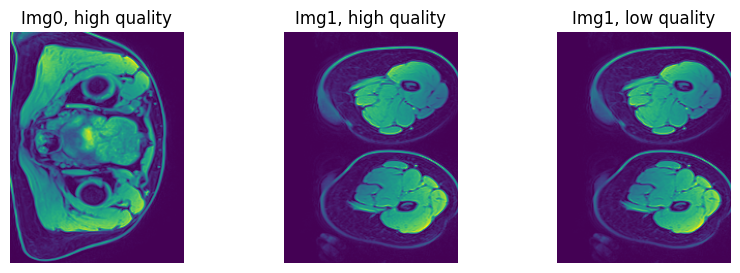

In [6]:
#noise = tio.Compose([tio.transforms.RandomMotion(num_transforms=1)])
noise = tio.Compose([tio.transforms.RandomNoise()])

idx0 = 22
idx1 = idx0
patient0 = 0
patient1 = 5

slice0 = load_slice_nako(patient0,idx0)
slice1 = load_slice_nako(patient1,idx1)
slice1_noise = load_slice_nako(patient1,idx1, None)

fig, axis = plt.subplots(1, 3, figsize=(10,3))
axis[0].imshow(slice0[0][:, 28:-28])
axis[0].set_title("Img0, high quality")
axis[1].imshow(slice1[0][:, 28:-28])
axis[1].set_title("Img1, high quality")

axis[2].imshow(slice1_noise[0][:, 28:-28])
axis[2].set_title("Img1, low quality")

axis[0].axis("off")
axis[1].axis("off")
axis[2].axis("off")


pred0 = model(slice0.unsqueeze(0).to(device))
pred1 = model(slice1.unsqueeze(0).to(device))
pred1_noise = model(slice1_noise.unsqueeze(0).to(device))

print(f"Similarity between high quality images:{F.cosine_similarity(pred0, pred1).item()}")
print(f"Similarity between low quality images:{F.cosine_similarity(pred0, pred1_noise).item()}")


In [ ]:
def load_slice_nako(subj_idx, idx, noise=None, zoom=60):
    if noise:
        slice = noise(nako_iqa_dataset[subj_idx])["data"]["data"][0,20:-20,:224,idx].unsqueeze(0)
    else:
        slice = nako_iqa_dataset[subj_idx]["data"]["data"][0,zoom:-zoom,zoom:-zoom,idx].unsqueeze(0)
        
    slice = torchvision.transforms.functional.resize(slice, [224, 224])
    #slice = np.pad(slice, ((0,0), (28,28)))
    #slice = torch.from_numpy(slice)
    return slice

def load_slice_nako_deep(subj_idx, idx, noise=None, zoom=60):
    if noise:
        slice = noise(nako_iqa_dataset_deep[subj_idx])["data"]["data"][0,20:-20,:224,idx].unsqueeze(0)
    else:
        slice = nako_iqa_dataset_deep[subj_idx]["data"]["data"][0,zoom:-zoom,zoom:-zoom,idx].unsqueeze(0)
        
    slice = torchvision.transforms.functional.resize(slice, [224, 224])
    #slice = np.pad(slice, ((0,0), (28,28)))
    #slice = torch.from_numpy(slice)
    return slice

Similarity between high quality images:0.9585952758789062
Similarity between low quality images:0.9285946488380432


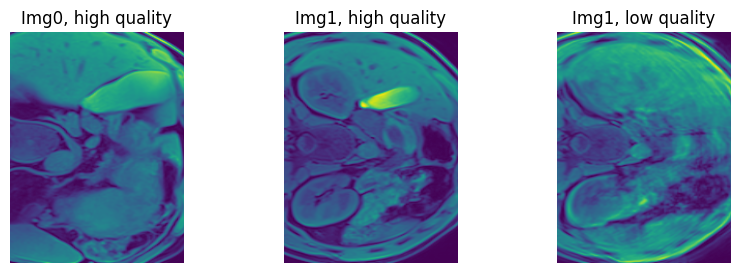

In [ ]:
#noise = tio.Compose([tio.transforms.RandomMotion(num_transforms=1)])
noise = tio.Compose([tio.transforms.RandomNoise()])

idx0 = 121
idx1 = idx0
patient0 = 0
patient1 = 1

slice0 = load_slice_nako(patient0,idx0)
slice1 = load_slice_nako(patient1,idx1)
slice1_noise = load_slice_nako_deep(patient1,idx1)

fig, axis = plt.subplots(1, 3, figsize=(10,3))
axis[0].imshow(slice0[0][:, 28:-28])
axis[0].set_title("Img0, high quality")
axis[1].imshow(slice1[0][:, 28:-28])
axis[1].set_title("Img1, high quality")

axis[2].imshow(slice1_noise[0][:, 28:-28])
axis[2].set_title("Img1, low quality")

axis[0].axis("off")
axis[1].axis("off")
axis[2].axis("off")


pred0 = model(slice0.unsqueeze(0).to(device))
pred1 = model(slice1.unsqueeze(0).to(device))
pred1_noise = model(slice1_noise.unsqueeze(0).to(device))

print(f"Similarity between high quality images:{F.cosine_similarity(pred0, pred1).item()}")
print(f"Similarity between low quality images:{F.cosine_similarity(pred0, pred1_noise).item()}")


In [ ]:
class IQA:
    def __init__(self, subj_idx):
            self.data = nako_iqa_dataset[subj_idx]["data"]["data"]
            self.data_deep = nako_iqa_dataset_deep[subj_idx]["data"]["data"]
            
    def grab_slice(self, idx, zoom=60):
        slice =  self.data[0,zoom:-zoom,zoom:-zoom,idx].unsqueeze(0)
        slice = torchvision.transforms.functional.resize(slice, [224, 224])
        
        slice_deep =  self.data_deep[0,zoom:-zoom,zoom:-zoom,idx].unsqueeze(0)
        slice_deep = torchvision.transforms.functional.resize(slice_deep, [224, 224])

        return slice, slice_deep

In [ ]:
iqa_patients = [IQA(i) for i in range(19)]

In [ ]:
for patient_idx_0 in range(20):
    print(patient_idx_0)
    patient_0 = iqa_patients[patient_idx_0]
    for patient_idx_1 in range(20):
        patient_1 = iqa_patients[patient_idx_1]
        
        if patient_idx_0 == patient_idx_1:
            continue

        for slice_idx in range(200):

            slice0 = patient_0.grab_slice(slice_idx)[0]
            slice1 = patient_1.grab_slice(slice_idx)[0]
            slice1_noise = patient_1.grab_slice(slice_idx)[1]
            pred0 = model(slice0.unsqueeze(0).to(device))
            pred1 = model(slice1.unsqueeze(0).to(device))
            pred1_noise = model(slice1_noise.unsqueeze(0).to(device))
            
            sim_high_quality = F.cosine_similarity(pred0, pred1).item()
            sim_low_quality = F.cosine_similarity(pred0, pred1_noise).item()
            
            if sim_low_quality > sim_high_quality and abs(sim_low_quality - sim_high_quality) > 0.03:
                print("ERROR:", patient_idx_0, patient_idx_1, slice_idx)

            if  (sim_high_quality - sim_low_quality) > 0.05:
                print("High noise:", patient_idx_0, patient_idx_1, slice_idx)



In [6]:
good_idx = list(range(0, 50))

In [7]:
noise = tio.Compose([tio.transforms.RandomNoise(mean=0, std=(0, 0.5))])


In [ ]:
good_features = []
for idx in good_idx:
    img = val_dataset[idx]["data"]["data"].unsqueeze(0).to(device)
    with torch.no_grad():
        good_features.append(model(img)[0])
    
good_features = torch.stack(good_features)

In [ ]:
bad_features = []
for idx in good_idx:
    img = noise(val_dataset[idx])["data"]["data"].unsqueeze(0).to(device)
    with torch.no_grad():
        bad_features.append(model(img)[0])
    
bad_features = torch.stack(bad_features)

Val Daten: /mnt/qdata/rawdata/NAKO_IQA/Images/Q1/dicom_sorted

In [15]:
idx1 = 64

noise2 = tio.transforms.RandomNoise(mean=0, std=(0, 0.5))
v1 = val_dataset[idx1]["data"]["data"].unsqueeze(0).to(device)

with torch.no_grad():
    pred1 = model(v1)


cosine_good = F.cosine_similarity(pred1, good_features).mean()
cosine_bad = F.cosine_similarity(pred1, bad_features).mean()

print(cosine_good, cosine_bad)
if cosine_good > cosine_bad:
    print("Image is likely to be of good quality")
else:
    print("Image is likely to be of bad quality")
    
torch.cuda.empty_cache()



plt.figure()
plt.imshow(v1[0,0,:,50,:].cpu())


TypeError: cosine_similarity(): argument 'x2' (position 2) must be Tensor, not list

In [ ]:
preprocessings = tio.transforms.Compose([
            tio.transforms.ZNormalization(),
            tio.RescaleIntensity((-1, 1))
        ])


nako_iqa_dataset = NakoIQADataset("/media/marci/data/NAKO_IQA/NAKO_IQA_nifti/", preprocessings)

In [ ]:
nako_iqa_dataset[0]

In [ ]:
nako_iqa_dataset.subjects

In [ ]:
def load_slice_nako(subj_idx, idx, noise=None):
    if noise:
        slice = noise(nako_iqa_dataset[subj_idx])["data"]["data"][0,20:-20,:224,idx].unsqueeze(0)
    else:
        slice = nako_iqa_dataset[subj_idx]["data"]["data"][0,20:-20,:224,idx].unsqueeze(0)
    print(slice.shape)
    slice = torchvision.transforms.functional.resize(slice, [224, 224])
    #slice = np.pad(slice, ((0,0), (28,28)))
    #slice = torch.from_numpy(slice)
    return slice

In [ ]:
test = load_slice_nako(0, 150)
plt.figure()
plt.imshow(test[0])